# Radiative cooling profiles with RRTMG
## Response to varying CO$_2$ and Snowball Earth

In [3]:
import numpy as np
import climlab
from matplotlib import pyplot as plt

Choose some parameters and a vertical grid. (I'm here using evenly spaced pressure levels.)

In [48]:
# alpha is tuned to get about the right global mean surface temperature in RRTMG.
alpha=0.27 
g=9.81
S0=1360.
coszen=0.58 # This follows Tim' paper (https://doi.org/10.1175/JAS-D-13-0392.1) (ideal for clearsky)
S0eff=S0/4./coszen   # This follows Tim' paper (https://doi.org/10.1175/JAS-D-13-0392.1)
Nlev=100
p0=1000.
R=287.
cp=1004;
climlab.constants.ps=p0 # this sets the surface pressure
p=np.linspace(p0/Nlev/2.,p0-p0/Nlev/2,Nlev)

## Creating Column Model

Here we set up a model with RRTMG using the Manabe RH profile

In [49]:
# This sets the initial state and defines the domain:
state_rrtmg_rce = climlab.column_state(lev=p, num_lat=1, water_depth=1.)
# This creates a time-dependent parent process
rrtmg_rce = climlab.TimeDependentProcess(state=state_rrtmg_rce)
# Water vapor:
rrtmg_h2o = climlab.radiation.ManabeWaterVapor(state=rrtmg_rce.state,qStrat=3e-06)
# radiation:
rrtmg_rad= climlab.radiation.RRTMG(state=state_rrtmg_rce, specific_humidity=rrtmg_h2o.q, S0=S0eff, albedo=alpha ,coszen=coszen)
rrtmg_rad.input['absorber_vmr']['CO2']=280./1.e6
# Hard convective adjustment to moist adiabat - notice that the "adj_lapse_rate" parameter here is in K/km though!
rrtmg_conv = climlab.convection.ConvectiveAdjustment(state=state_rrtmg_rce, adj_lapse_rate='MALR')
# Now we couple it all together:
rrtmg_rce.add_subprocess('WV',rrtmg_h2o)
rrtmg_rce.add_subprocess('Radiation', rrtmg_rad)
rrtmg_rce.add_subprocess('ConvectiveAdjustment', rrtmg_conv)

Now we Integrate the model forward:

In [50]:
rrtmg_rce.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


Finally, let's look at radiative-convective equilibrium (RCE) solutions

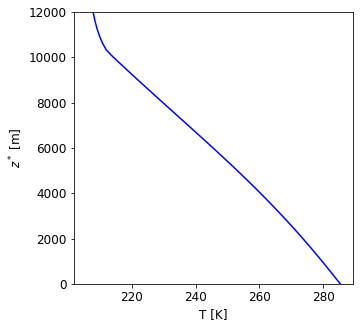

Ts=$ [285.34957623]


In [51]:
Trce_rrtmg=np.append(rrtmg_rce.state.Tatm,rrtmg_rce.state.Ts)
pvec=np.append(p,p0)

plt.figure(figsize=(5,5))
plt.plot(Trce_rrtmg,-8000*np.log(pvec/1000.),'b-',label='RRTMG radiation')
#plt.ylim(1013, 0)
plt.ylim(0,12000)
plt.xlabel('T [K]')
plt.ylabel('$z^*$ [m]')
#plt.legend()
plt.show()
print('Ts=$',rrtmg_rce.state.Ts)

## CO2 response

In [52]:
# here we set up three rrtmg models: a control case, a case with doubled CO2, and a case with doubled CO2 and solar dimming
# we here again use a moist adiabatic lapse rate
rce=climlab.process_like(rrtmg_rce)
rce.subprocess.ConvectiveAdjustment.adj_lapse_rate='MALR'

rce_warm=climlab.process_like(rce)
# then we double CO2 concentration:
CO2_old=1.0*rce.subprocess.Radiation.input['absorber_vmr']['CO2']
print('control CO2 concentration [ppm]:',CO2_old*1e6)
rce_warm.subprocess.Radiation.input['absorber_vmr']['CO2']=2.*CO2_old
print('warm CO2 concentration [ppm]:',rce_warm.subprocess.Radiation.input['absorber_vmr']['CO2']*1e6)

control CO2 concentration [ppm]: 280.0
warm CO2 concentration [ppm]: 560.0


In [53]:
rce.integrate_years(3)
rce_warm.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 7.997432936281733 years.
Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 7.997432936281733 years.


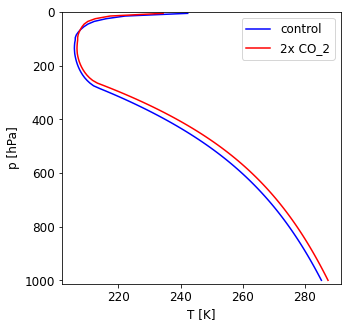

Ts_cont= [285.34957623]
Ts_warm= [287.48373944]


In [54]:
T_cont=rce.state.Tatm
T_cont=np.append(T_cont,rce.state.Ts)
T_warm=rce_warm.state.Tatm
T_warm=np.append(T_warm,rce_warm.state.Ts)
plt.figure(figsize=(5,5))
plt.plot(T_cont,pvec,'b-',label='control')
plt.plot(T_warm,pvec,'r-',label='2x CO_2')
plt.ylim(1013, 0)
plt.xlabel('T [K]')
plt.ylabel('p [hPa]')
plt.legend()
plt.show()
print('Ts_cont=',rce.state.Ts)
print('Ts_warm=',rce_warm.state.Ts)

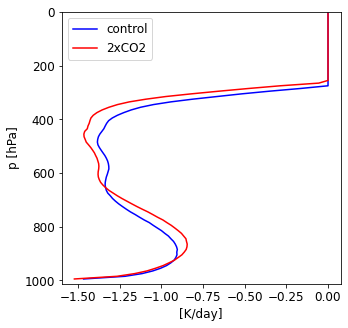

In [55]:
LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
LWtend_warm=rce_warm.subprocess.Radiation.diagnostics['TdotLW']
SWtend_warm=rce_warm.subprocess.Radiation.diagnostics['TdotSW']

plt.figure(figsize=(5,5))
#plt.plot(LWtend,p,'g--',label='LW cont')
#plt.plot(SWtend,p,'g:',label='SW cont')
plt.plot(SWtend+LWtend,p,'b-',label='control')
#plt.plot(LWtend_warm,p,'b--',label='LW warm')
#plt.plot(SWtend_warm,p,'r--',label='SW warm')
plt.plot(SWtend_warm+LWtend_warm,p,'r-',label='2xCO2')
plt.ylim(1013, 0)
plt.xlabel('[K/day]')
plt.ylabel('p [hPa]')
plt.legend()
plt.show()

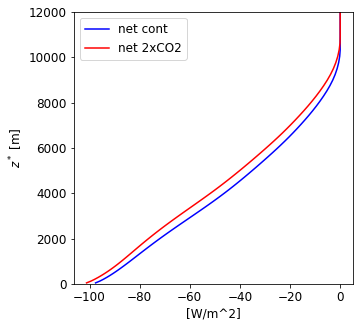

In [56]:
dp=p[1]-p[0]
F_cont=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)  # W/m^2 (notice the *100 is to accout for p being in hPa)
F_warm=np.cumsum((SWtend_warm+LWtend_warm)*dp/g*cp/86400.*100.)

plt.figure(figsize=(5,5))
plt.plot(F_cont,-8000*np.log(p/1000.),'b-',label='net cont')
plt.plot(F_warm,-8000*np.log(p/1000.),'r-',label='net 2xCO2')
plt.ylim(0,12000)
plt.xlabel('[W/m^2]')
plt.ylabel('$z^*$ [m]')
plt.legend()
plt.show()

In [57]:
p_i=(p[:-1]+p[1:])/2
p_i=np.append(p_i,p[-1]+dp/2.)
dlogp=np.log(p_i[1:]/p_i[:-1])
print('F_LW_cont dz =',sum(np.cumsum(LWtend*dp/g*cp/86400.*100.)[1:]*dlogp))
print('F_LW_warm dz =',sum(np.cumsum(LWtend_warm*dp/g*cp/86400.*100.)[1:]*dlogp))
print('F_cont dz =',sum(F_cont[1:]*dlogp))
print('F_warm dz =',sum(F_warm[1:]*dlogp))
print('d<[Q]>/<[Q]> [%%/K]= %.1f' % ((sum(F_warm[1:]*dlogp)/sum(F_cont[1:]*dlogp)-1)/(rce_warm.state.Ts-rce.state.Ts)*100.)) 
# ralative change in ,<Q_{rad}>  in %/K  (This controls precip changes)
print('d<Q>/<Q> [%%/K]= %.1f' %  ((F_warm[-1]/F_cont[-1]-1)/(rce_warm.state.Ts-rce.state.Ts)*100.))

F_LW_cont dz = -126.29381322160118
F_LW_warm dz = -134.5000327862735
F_cont dz = -49.49790741212565
F_warm dz = -54.55126091398262
d<[Q]>/<[Q]> [%/K]= 4.8
d<Q>/<Q> [%/K]= 1.7


In [58]:
# Now with fixed lapse rate of 6.5 K/km

rce=climlab.process_like(rrtmg_rce)
rce.subprocess.ConvectiveAdjustment.adj_lapse_rate=6.5

rce_warm=climlab.process_like(rce)
# here we double CO2 concentration:
CO2_old=1.0*rce.subprocess.Radiation.input['absorber_vmr']['CO2']
print('control CO2 concentration [ppm]:',CO2_old*1e6)
rce_warm.subprocess.Radiation.input['absorber_vmr']['CO2']=2.*CO2_old
print('warm CO2 concentration [ppm]:',rce_warm.subprocess.Radiation.input['absorber_vmr']['CO2']*1e6)

rce.integrate_years(3)
rce_warm.integrate_years(3)

print('Ts_cont=',rce.state.Ts)
print('Ts_warm=',rce_warm.state.Ts)

LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
LWtend_warm=rce_warm.subprocess.Radiation.diagnostics['TdotLW']
SWtend_warm=rce_warm.subprocess.Radiation.diagnostics['TdotSW']
dp=p[1]-p[0]
F_cont=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)
F_warm=np.cumsum((SWtend_warm+LWtend_warm)*dp/g*cp/86400.*100.)
p_i=(p[:-1]+p[1:])/2
p_i=np.append(p_i,p[-1]+dp/2.)
dlogp=np.log(p_i[1:]/p_i[:-1])
print('F_LW_cont dz =',sum(np.cumsum(LWtend*dp/g*cp/86400.*100.)[1:]*dlogp))
print('F_LW_warm dz =',sum(np.cumsum(LWtend_warm*dp/g*cp/86400.*100.)[1:]*dlogp))
print('F_cont dz =',sum(F_cont[1:]*dlogp))
print('F_warm dz =',sum(F_warm[1:]*dlogp))
print('d<[Q]>/<[Q]> [%%/K]= %.1f' % ((sum(F_warm[1:]*dlogp)/sum(F_cont[1:]*dlogp)-1)/(rce_warm.state.Ts-rce.state.Ts)*100.)) 
# ralative change in ,<Q_{rad}>  in %/K  (This controls precip changes)
print('d<Q>/<Q> [%%/K]= %.1f' %  ((F_warm[-1]/F_cont[-1]-1)/(rce_warm.state.Ts-rce.state.Ts)*100.))

control CO2 concentration [ppm]: 280.0
warm CO2 concentration [ppm]: 560.0
Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 7.997432936281733 years.
Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 7.997432936281733 years.
Ts_cont= [285.41106701]
Ts_warm= [287.76742985]
F_LW_cont dz = -132.25050232029344
F_LW_warm dz = -138.2124975808307
F_cont dz = -54.38843541757831
F_warm dz = -57.804520810388766
d<[Q]>/<[Q]> [%/K]= 2.7
d<Q>/<Q> [%/K]= 1.3


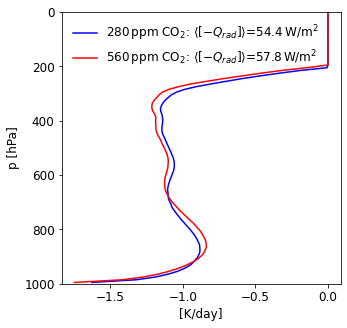

In [59]:
Qcont=sum(F_cont[1:]*dlogp)
Qwarm=sum(F_warm[1:]*dlogp)
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 12})
#plt.plot(LWtend,p,'g--',label='LW cont')
#plt.plot(SWtend,p,'g:',label='SW cont')
plt.plot(SWtend+LWtend,p,'b-',label=rf'280$\,$ppm CO$_2$: $\langle[-Q_{{rad}}]\rangle$={-Qcont:.1f}$\,$W/m$^2$')
#plt.plot(LWtend_warm,p,'b--',label='LW warm')
#plt.plot(SWtend_warm,p,'r--',label='SW warm')
plt.plot(SWtend_warm+LWtend_warm,p,'r-',label=rf'560$\,$ppm CO$_2$: $\langle[-Q_{{rad}}]\rangle$={-Qwarm:.1f}$\,$W/m$^2$')
plt.ylim(1000, 0)
plt.xlabel('[K/day]')
plt.ylabel('p [hPa]')
plt.legend(frameon=False)
plt.savefig('Q_CO2_response', dpi=600, bbox_inches='tight')
plt.show()

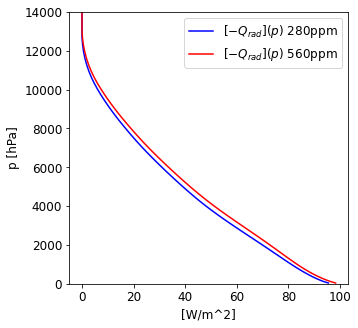

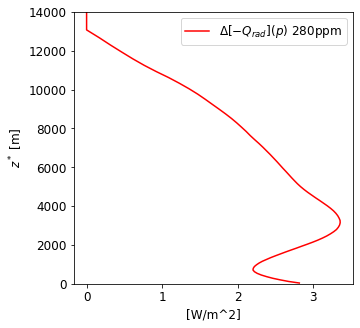

In [60]:
F_cont=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)  # W/m^2 (notice the *100 is to accout for p being in hPa)
F_warm=np.cumsum((SWtend_warm+LWtend_warm)*dp/g*cp/86400.*100.)

plt.figure(figsize=(5,5))
plt.plot(-F_cont,-8000*np.log(p/1000.),'b-',label='$[-Q_{rad}](p)$ 280ppm')
plt.plot(-F_warm,-8000*np.log(p/1000.),'r-',label='$[-Q_{rad}](p)$ 560ppm')
plt.ylim(0,14000)
plt.xlabel('[W/m^2]')
plt.ylabel('p [hPa]')
plt.legend()
plt.show()


plt.figure(figsize=(5,5))
plt.plot(-F_warm+F_cont,-8000*np.log(p/1000.),'r-',label='$\Delta [-Q_{rad}](p)$ 280ppm')
plt.ylim(0,14000)
plt.xlabel('[W/m^2]')
plt.ylabel('$z^*$ [m]')
plt.legend()
plt.show()

# Snowball Earth

In [64]:
# Withfixed Lapse rate of 6.5K/km (this is significanlty more realistic than MALR - indeed the larger Eq-pole t grad tends to lead to more stable LR in gcms)

rce=climlab.process_like(rrtmg_rce)
rce.subprocess.ConvectiveAdjustment.adj_lapse_rate=6.5
# switch the WV scheme (in case it's not the right one already)
rce.remove_subprocess('WV')
h2o = climlab.radiation.ManabeWaterVapor(state=rce.state,qStrat=3e-06)
rce.add_subprocess('WV',h2o)
# now we switch out the radiation schemes - where we include the interactive water vapor as input for specific hum.
rce.remove_subprocess('Radiation')
rad=climlab.radiation.RRTMG(state=rce.state, specific_humidity=rce.subprocess.WV.q , S0=S0eff, albedo=alpha ,coszen=coszen)
rad.input['absorber_vmr']['CO2']=400./1.e6
rce.add_subprocess('Radiation',rad)

rce_snowball=climlab.process_like(rce)
rce_snowball.subprocess.ConvectiveAdjustment.adj_lapse_rate=6.5
rce_snowball.remove_subprocess('Radiation')
# Increase albedo to 0.65
rad_snowball=climlab.radiation.RRTMG(state=rce_snowball.state, specific_humidity=rce_snowball.subprocess.WV.q , S0=S0eff, albedo=0.65 ,coszen=coszen)
rce_snowball.add_subprocess('Radiation',rad_snowball)

rce.integrate_years(3)
rce_snowball.integrate_years(3)

print('Ts_control=',rce.state.Ts)
print('Ts_snowball=',rce_snowball.state.Ts)

LWtend=rce.subprocess.Radiation.diagnostics['TdotLW']
SWtend=rce.subprocess.Radiation.diagnostics['TdotSW']
LWtend_snowball=rce_snowball.subprocess.Radiation.diagnostics['TdotLW']
SWtend_snowball=rce_snowball.subprocess.Radiation.diagnostics['TdotSW']
dp=p[1]-p[0]
F_cont=np.cumsum((SWtend+LWtend)*dp/g*cp/86400.*100.)
F_snowball=np.cumsum((SWtend_snowball+LWtend_snowball)*dp/g*cp/86400.*100.)
p_i=(p[:-1]+p[1:])/2
p_i=np.append(p_i,p[-1]+dp/2.)
dlogp=np.log(p_i[1:]/p_i[:-1])
print('F_control dz =',sum(F_cont[1:]*dlogp))
print('F_snowball dz =',sum(F_snowball[1:]*dlogp))

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 7.997432936281733 years.
Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 7.997432936281733 years.
Ts_control= [286.59391652]
Ts_snowball= [230.20018612]
F_control dz = -56.103417634967634
F_snowball dz = -4.846654495815391


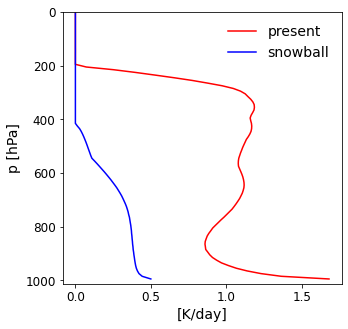

In [65]:
plt.figure(figsize=(5,5))
#plt.plot(LWtend,p,'g--',label='LW cont')
#plt.plot(SWtend,p,'g:',label='SW cont')
plt.plot(-SWtend-LWtend,p,'r-',label='present')
#plt.plot(LWtend_warm,p,'b--',label='LW warm')
#plt.plot(SWtend_warm,p,'r--',label='SW warm')
plt.plot(-SWtend_snowball-LWtend_snowball,p,'b-',label='snowball')
plt.ylim(1013, 0)
plt.xlabel('[K/day]',fontsize=14)
plt.ylabel('p [hPa]',fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.tick_params(labelsize=12)
plt.show()

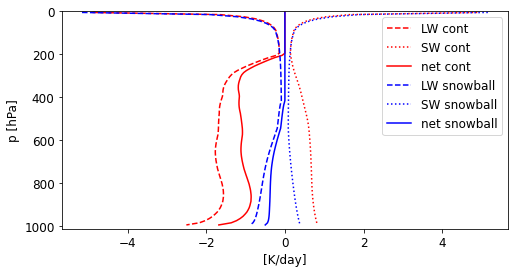

In [66]:
plt.figure(figsize=(8,4))
plt.plot(LWtend,p,'r--',label='LW cont')
plt.plot(SWtend,p,'r:',label='SW cont')
plt.plot(SWtend+LWtend,p,'r-',label='net cont')
plt.plot(LWtend_snowball,p,'b--',label='LW snowball')
plt.plot(SWtend_snowball,p,'b:',label='SW snowball')
plt.plot(SWtend_snowball+LWtend_snowball,p,'b-',label='net snowball')
plt.ylim(1013, 0)
plt.xlabel('[K/day]')
plt.ylabel('p [hPa]')
plt.legend()
plt.show()